![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/streamlit_notebooks/ocr/SKEW_CORRECTION.ipynb)

# Correct skewness in scanned documents 

To run this yourself, you will need to upload your **Spark OCR** license keys to the notebook. Otherwise, you can look at the example outputs at the bottom of the notebook. To upload license keys, open the file explorer on the left side of the screen and upload `workshop_license_keys.json` to the folder that opens.

For more in-depth tutorials: https://github.com/JohnSnowLabs/spark-ocr-workshop/tree/master/jupyter

## 1. Colab Setup

Install correct version of Pillow and Restart runtime

In [1]:
# Install correct Pillow version
import PIL
if PIL.__version__  != '6.2.1':
  print ('Installing correct version of Pillow. Kernel will restart automatically')
  !pip install --upgrade pillow==6.2.1
  # hard restart runtime
  import os
  os.kill(os.getpid(), 9)
else:
  print ('Correct Pillow detected')

Correct Pillow detected


Read licence key

In [2]:
import os
import json

with open('workshop_license_keys.json') as f:
    license_keys = json.load(f)

print (license_keys.keys())

secret = license_keys['JSL_OCR_SECRET']
os.environ['SPARK_OCR_LICENSE'] = license_keys['SPARK_OCR_LICENSE']
os.environ['JSL_OCR_LICENSE'] = license_keys['SPARK_OCR_LICENSE']
version = secret.split("-")[0]
print ('Spark OCR Version:', version)

dict_keys(['JSL_OCR_SECRET', 'SPARK_OCR_LICENSE'])
Spark OCR Version: 1.5.0


Install Dependencies

In [ ]:
# Install Java
!apt-get update
!apt-get install -y openjdk-8-jdk
!java -version

# Install pyspark, SparkOCR, and SparkNLP
!pip install --ignore-installed -q pyspark==2.4.4
# Insall Spark Ocr from pypi using secret
!python -m pip install --upgrade spark-ocr==$version  --extra-index-url https://pypi.johnsnowlabs.com/$secret
# or install from local path
# %pip install --user ../../python/dist/spark-ocr-[version].tar.gz
!pip install --ignore-installed -q spark-nlp==2.5.2

Importing Libraries

In [4]:
import pandas as pd
import numpy as np
import os

#Pyspark Imports
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

# Necessary imports from Spark OCR library
from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image, to_pil_image
from sparkocr.metrics import score
import pkg_resources

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]


Start Spark Session

In [5]:
spark = start(secret=secret)
spark

## 2. Load skewed scanned text image

In [7]:
rotatedPDF = pkg_resources.resource_filename('sparkocr', 'resources/ocr/pdfs/rotated/400/400_rot.pdf')
image_df = spark.read.format("binaryFile").load(rotatedPDF).cache()

## 3. Construct the OCR pipeline

In [10]:
pdf_to_image = PdfToImage()
pdf_to_image.setInputCol("content")
pdf_to_image.setOutputCol("image")

# Image skew corrector 
skew_corrector = ImageSkewCorrector()
skew_corrector.setInputCol("image")
skew_corrector.setOutputCol("corrected_image")
skew_corrector.setAutomaticSkewCorrection(True)

# Run OCR
ocr = ImageToText()
ocr.setInputCol("corrected_image")
ocr.setOutputCol("text")

pipeline = PipelineModel(stages=[
    pdf_to_image,
    skew_corrector,
    ocr
])

## 4. Run OCR pipeline

In [11]:
result = pipeline.transform(image_df).cache()

## 5. Visualize Results

Display result dataframe

In [12]:
result.select("text", "confidence").show()

+--------------------+-----------------+
|                text|       confidence|
+--------------------+-----------------+
|FOREWORD

Electro...|96.03673458099365|
+--------------------+-----------------+



Display text and images

Image:
        origin: file:/usr/local/lib/python3.6/dist-packages/sparkocr/resources/ocr/pdfs/rotated/400/400_rot.pdf 
        width: 2480
        height: 3507
        mode: 10


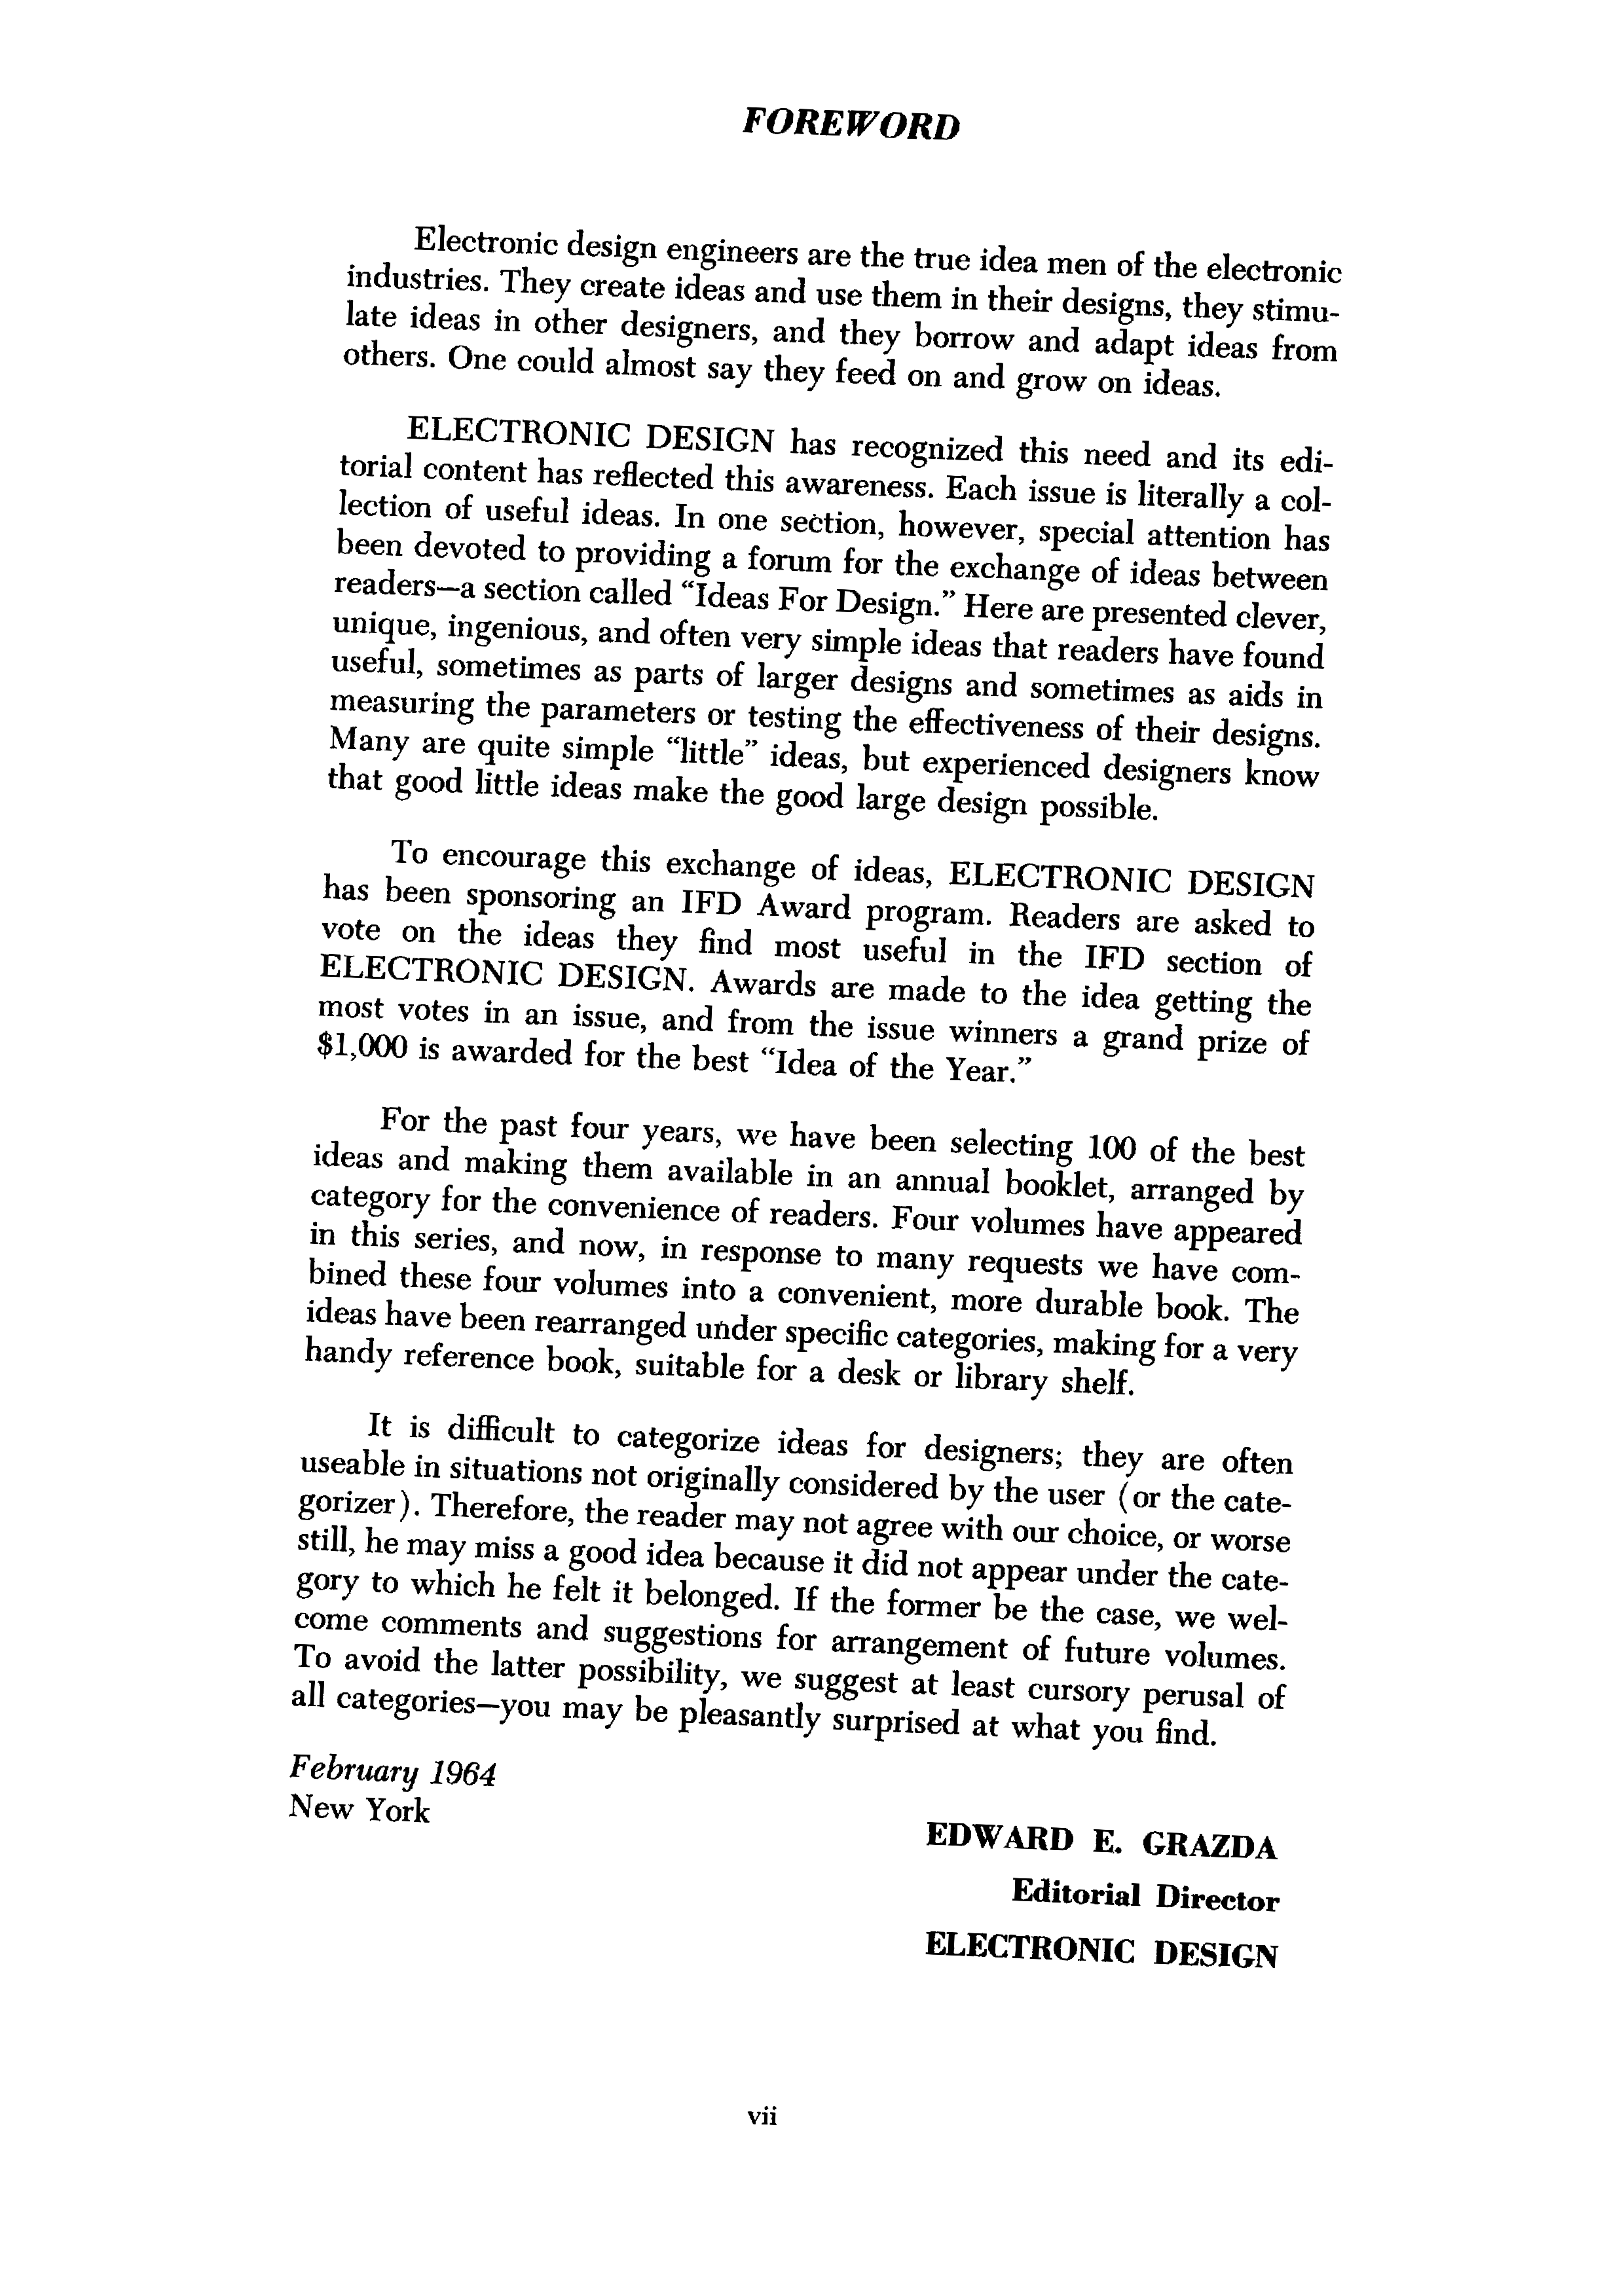

Image:
        origin: file:/usr/local/lib/python3.6/dist-packages/sparkocr/resources/ocr/pdfs/rotated/400/400_rot.pdf 
        width: 2600
        height: 3591
        mode: 10


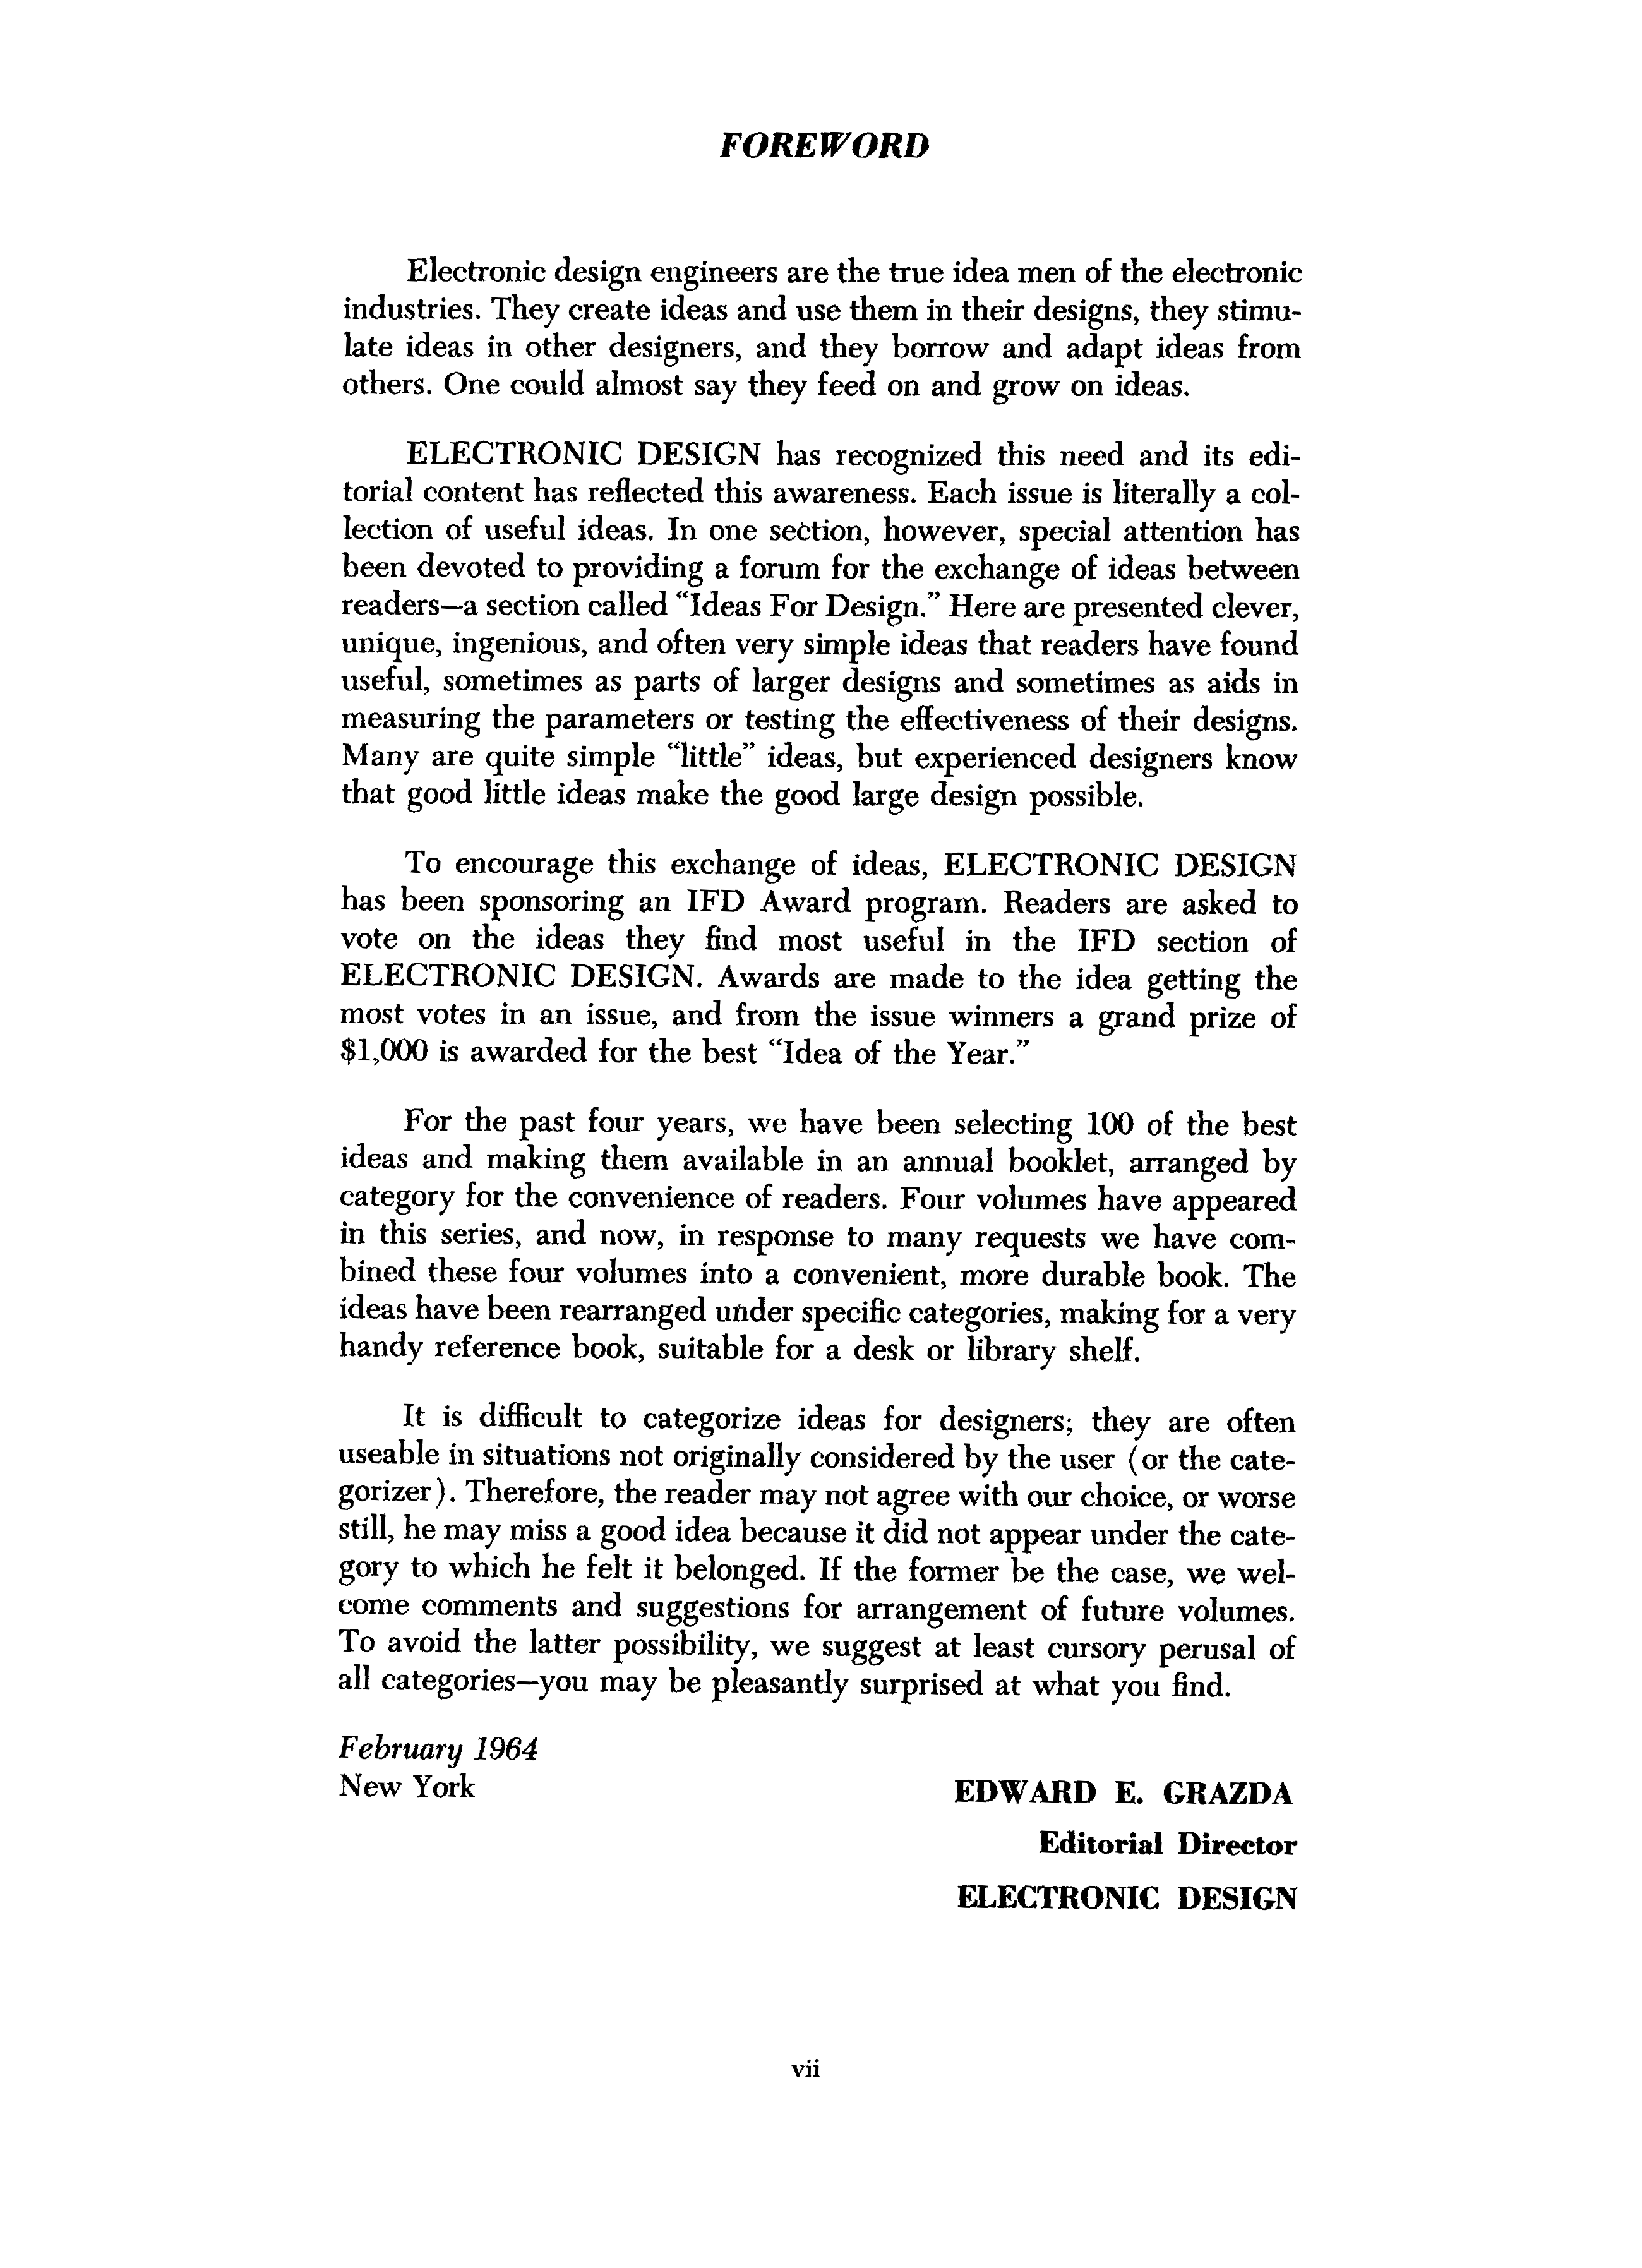

FOREWORD

Electronic design engineers are the true idea men of the electronic
industries. They create ideas and use them in their designs, they stimu-
late ideas in other designers, and they borrow and adapt ideas from
others. One could almost say they feed on and grow on ideas.

ELECTRONIC DESIGN has recognized this need and its edi-
torial content has reflected this awareness. Each issue is literally a col-
lection of useful ideas. In one section, however, special attention has
been devoted to providing a forum for the exchange of ideas between
readers—a section called “Ideas For Design.” Here are presented clever,
unique, ingenious, and often very simple ideas that readers have found
useful, sometimes as parts of larger designs and sometimes as aids in
measuring the parameters or testing the effectiveness of their designs.
Many are quite simple “little” ideas, but experienced designers know
that good little ideas make the good large design possible.

To encourage this exchange of id

In [14]:
for r in result.distinct().collect():
  display_image(r.image)
  display_image(r.corrected_image)
  print (r.text)

Saving intermediate processing results as jpg

In [15]:
for r in result.distinct().collect():

    img = to_pil_image(r.corrected_image, r.corrected_image.mode)
    img.save('corrected.jpg')
